In [1]:
# CHECK IF RUNNING INSIDE GOOGLE.COLAB

import sys
import os

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_walkthrough
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_walkthrough')
    # change working directory to project root
    os.chdir('/content/ts_walkthrough')
    # install requirements
    !pip install -r requirements.txt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [243]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

from load_dataset import Dataset
import plotting

In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
dataset = Dataset('../../data/dataset')

In [247]:
ts = dataset['international-airline-passengers.csv']
ts.index = ts.index.map(pd.to_datetime)

/home/nikita/Документы/time_series_course/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [248]:
ts, ts_test = ts[:100], ts[100:]

<Axes: xlabel='1949-01'>

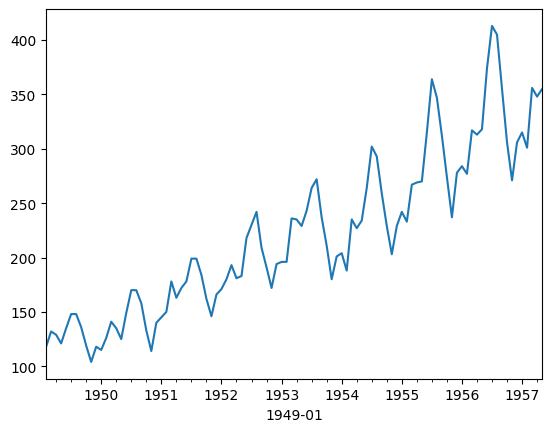

In [249]:
ts.plot()

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot и теста дикки-фуллера.
3. Найти (если модель разделима) или оценить (если не разделима) параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMAX и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели (в идеале) - стационарные остатки.

In [250]:
ts_log = np.log(ts)
plotting.plot_ts(ts_log)

Loading BokehJS ...

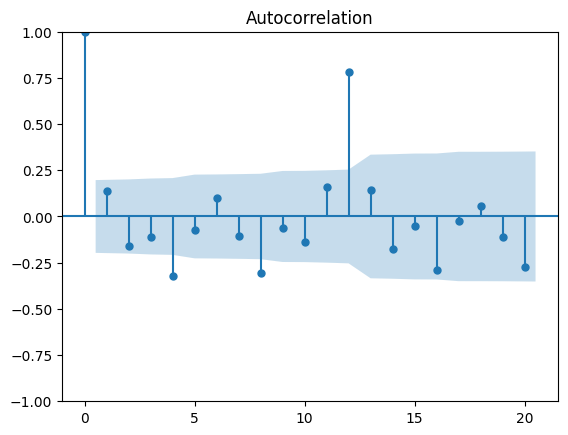

In [251]:
plot_acf(ts_log.diff().dropna());

In [252]:
#сезонность 12 

In [253]:
plotting.plot_ts(ts_log.diff().diff(12).dropna())

Loading BokehJS ...

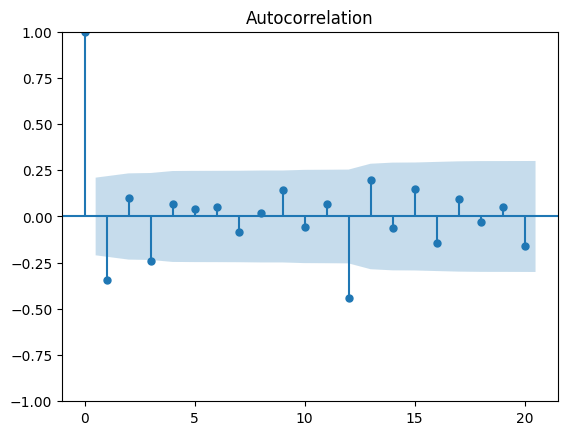

In [254]:
plot_acf(ts_log.diff().diff(12).dropna());

In [255]:
print(adfuller(ts_log.diff().diff(12).dropna())[1])

0.015576847255206597


In [209]:
#ряд стационарен на уровне значимости 2% (D,d) = 2,1

In [256]:
ts_flat = ts_log.diff().diff(12).dropna()

/home/nikita/Документы/time_series_course/ts_env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


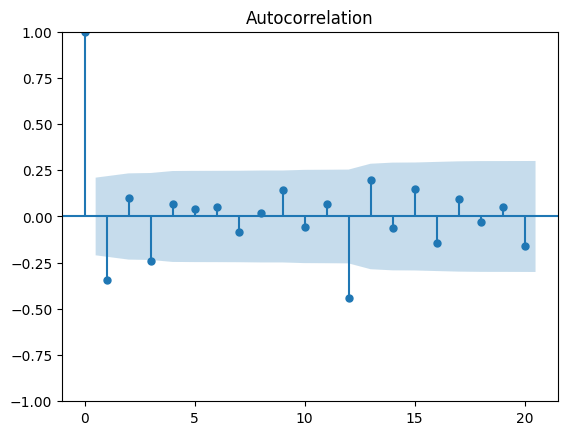

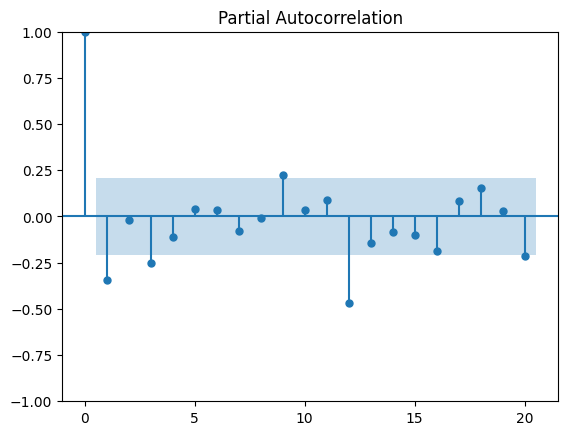

In [257]:
plot_acf(ts_flat.dropna());
plot_pacf(ts_flat);

p = 1 (последний значимый несезонный лаг PACF) \
q = 1 (последний значимый несезонный лаг ACF)

In [258]:
from statsmodels.tsa.statespace import sarimax

In [259]:
pdq = (1, 1, 1)
PDQ = (1, 1, 1, 12)

In [260]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/home/nikita/Документы/time_series_course/ts_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nikita/Документы/time_series_course/ts_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [261]:
res = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53800D+00    |proj g|=  5.22704D+00

At iterate    5    f= -1.55946D+00    |proj g|=  1.73547D-01

At iterate   10    f= -1.56797D+00    |proj g|=  2.16066D-01

At iterate   15    f= -1.56809D+00    |proj g|=  2.58324D-01

At iterate   20    f= -1.57296D+00    |proj g|=  1.12723D+00

At iterate   25    f= -1.57537D+00    |proj g|=  1.41168D-02

At iterate   30    f= -1.57576D+00    |proj g|=  9.15884D-02

At iterate   35    f= -1.58248D+00    |proj g|=  1.51147D-01

At iterate   40    f= -1.58272D+00    |proj g|=  2.35556D-02

At iterate   45    f= -1.58272D+00    |proj g|=  7.69078D-03

At iterate   50    f= -1.58272D+00    |proj g|=  2.23195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/nikita/Документы/time_series_course/ts_env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [262]:
preds = res.forecast(43)

In [263]:
plotting.plot_ts(ts_log, preds)

Loading BokehJS ...

In [264]:
res = (np.exp(preds) - ts_test)

<Axes: >

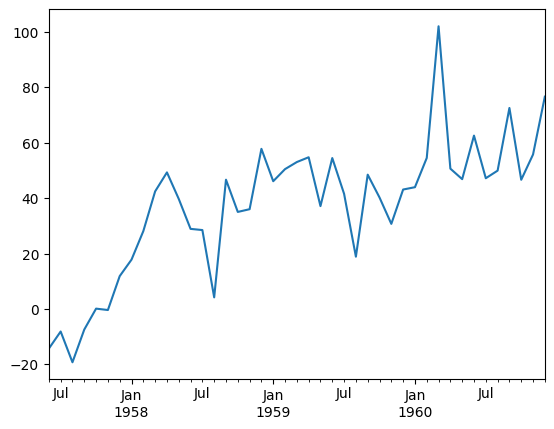

In [265]:
res.plot()

Модель не совсем правильно уловила тренд

In [266]:
plotting.plot_ts(ts_test, np.exp(preds))

Loading BokehJS ...

In [267]:
from sklearn.metrics import mean_squared_error as mse

mse(np.exp(preds), ts_test)

2004.4716679257542

In [268]:
# призамене (D,d) в параметрах SARIMAX на (2,2), предсказания становятся лучше, хотя с двойным деффиренцированием ряд явно меньше похож на стационарный

#### Задание 2. (используя auto-arima)
1. Установить аналог auto-arima из R, библиотеку pmdarima (pip install pmdarima)
2. Обучить модель, используя функцию auto_arima, передав в нее нужные параметры.

In [269]:
# наиболее удобная реализация AutoArima находится в модуле pmdarima
from pmdarima import auto_arima

In [270]:
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-274.966, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-302.371, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-309.686, Time=0.77 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-284.621, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-307.867, Time=1.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-307.883, Time=2.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-304.096, Time=0.51 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-305.846, Time=1.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-300.816, Time=0.56 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-308.392, Time=1.90 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-307.997, Time=1.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-308.462, Time=0.71 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-305.687, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-307.709, Time=1.43 sec

Best model:  ARIMA

In [271]:
model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [273]:
preds = model.predict(len(ts_test))

In [274]:
plotting.plot_ts(np.exp(ts_log), ts_test, pd.Series(np.exp(preds), index=ts_test.index))

Loading BokehJS ...

In [275]:
mse(np.exp(preds), ts_test)

1865.2273558574893

Незначительно, но лучше, чем ручным подбором параметров. Auto-arima посчитала, что p=0.